In [5]:
from typing import Tuple, Optional, Dict, List
import torch
from torch import Tensor
from torchvision.transforms.functional import pil_to_tensor

In [2]:
torch.device("cuda")


device(type='cuda')

In [3]:
from torchvision.datasets import MNIST
help(MNIST)

mnist_data =  MNIST(root=".", download=True)

Help on class MNIST in module torchvision.datasets.mnist:

class MNIST(torchvision.datasets.vision.VisionDataset)
 |  MNIST(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False) -> None
 |  
 |  `MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.
 |  
 |  Args:
 |      root (string): Root directory of dataset where ``MNIST/raw/train-images-idx3-ubyte``
 |          and  ``MNIST/raw/t10k-images-idx3-ubyte`` exist.
 |      train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
 |          otherwise from ``t10k-images-idx3-ubyte``.
 |      download (bool, optional): If True, downloads the dataset from the internet and
 |          puts it in root directory. If dataset is already downloaded, it is not
 |          downloaded again.
 |      transform (callable, optional): A function/transform that  takes in an PIL image
 |          and returns a transformed version. E.g, ``transfor

100%|██████████| 9912422/9912422 [00:01<00:00, 7261198.21it/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 264512.09it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2398042.21it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1466666.32it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [10]:
type(mnist_data)
sample = mnist_data[0]
MNIST_SIZE = pil_to_tensor(sample[0]).size()[1:]

display(sample[0]), print(sample[1]), MNIST_SIZE

5


(None, None, torch.Size([28, 28]))

In [11]:
def transform_img(img: "Image"):
    intermediate_img: Tensor = pil_to_tensor(img).to(float)
    return intermediate_img / 255

In [ ]:
import logging
logger = logging.getLogger(__name__)
logger = logging.getLogger("This")
logger.setLevel(logging.INFO)

# TODO change all layer to torch.nn.LAYERTYPE


class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # self.inp_layer: Tensor =  torch.rand(size=(MNIST_SIZE[0] * MNIST_SIZE[1], 20)).to(float)  # hidden dim=20
        self.inp_layer: Tensor =  torch.nn.Linear(in_features=MNIST_SIZE[0] * MNIST_SIZE[1], out_features=20).to(float)  # hidden dim=20
        # self.bias1: Tensor = torch.rand(20)
        # self.layer2_mu: Tensor = torch.rand(size=(20, 5)).to(float)
        self.layer2_mu: Tensor = torch.nn.Linear(in_features=20, out_features=5).to(float)
        self.layer2_sigma: Tensor = torch.rand(size=(20, 5)).to(float)
        self.layer2_sigma: Tensor = torch.nn.Linear(in_features=20, out_features=5).to(float)
        # self.bias2_mu: Tensor = torch.rand(size=(1, 5))
        # self.bias2_sigma: Tensor = torch.rand(size=(1, 5))
        self.distr: Optional[torch.distributions.Normal] = None
        return None

    def __forward__(self, x: Tensor):
        # encoder returns mu and log sigma^2

        x = x.to(float)
        x = self.inp_layer.T @ x
        print(x.size())
        x = torch.functional.F.tanh(x + self.bias1)


        mu = (self.layer2_mu.T @ x) + self.bias2_mu
        log_sigma = (self.layer2_sigma.T @ x) + self.bias2_sigma
        return (mu, log_sigma)

    def __call__(self, x: Tensor):
        return self.__forward__(x)


class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # 5 -> 100
        # 100 -> 784
        self.inp_layer: Tensor = torch.rand(size=(5, 100)).to(float)
        self.bias1: Tensor = torch.rand(size=(100, 1)).to(float)
        self.layer_1_mu: Tensor = torch.rand(size=(100, 784)).to(float)
        self.bias2_mu: Tensor = torch.rand(size=(784,1)).to(float)
        self.layer_1_sigma: Tensor = torch.rand(size=(100, 784)).to(float)
        self.bias2_sigma: Tensor = torch.rand(size=(784,1)).to(float)
        return None
        
    def __forward__(self, x: Tensor):
        x = x.to(float)
        logger.info(x.size())
        x = self.inp_layer.T @ x
        logger.info(x.size())
        x = torch.functional.F.tanh(x + self.bias1)
        logger.info(x.size())
        mu = (self.layer_1_mu.T @ x) + self.bias2_mu
        log_sigma = (self.layer_1_sigma.T @ x) + self.bias2_sigma
        logger.info((mu.size(), log_sigma.size()))
        return (mu, log_sigma)

    def __call__(self, x: Tensor):
        return self.__forward__(x)

class VAE(torch.nn.Module):
    def __init__(self, enc: Encoder, dec: Decoder):
        super(VAE, self).__init__()
        self.enc = enc
        self.dec = dec

    def __forward__(self, x: Tensor) -> Tensor:
        x_enc: Tuple[Tensor, Tensor] =  self.enc(x)
        latent_norm_enc: Dict[str, Tensor] = {"loc": x_enc[0], "scale": x_enc[1]}
        latent_distr: torch.distributions.Normal  = torch.distributions.Normal(**latent_norm_enc)
        latent_var: Tensor = latent_distr.rsample()
        reconstr_norm_dec: Tuple[Tensor, Tensor] = self.dec(latent_var.T)
        reconstr_norm_params: Dict[str, Tensor] = {"loc": reconstr_norm_dec[0], "scale": reconstr_norm_dec[1]}
        reconstr_distr: torch.distributions.Normal = torch.distributions.Normal(**reconstr_norm_params)
        reconstr_var: Tensor = reconstr_distr.rsample()
        return reconstr_var

    def __call__(self, x: Tensor):
        return self.__forward__(x)
        


In [81]:
enc = Encoder()
img_tens = transform_img(sample[0])

In [85]:
encods = Encoder()
[p.size() for p in encods.parameters()]

[torch.Size([20, 784]),
 torch.Size([20]),
 torch.Size([5, 20]),
 torch.Size([5]),
 torch.Size([5, 20]),
 torch.Size([5])]

In [ ]:
img_tens.dtype

torch.float64

In [69]:
y  = enc(img_tens.flatten())


torch.Size([20])


In [70]:
y

(tensor([[ 9.1137,  8.2757,  9.2472,  9.5994, 10.9600]], dtype=torch.float64),
 tensor([[ 9.9974, 10.5737, 11.2153, 11.0252, 11.3905]], dtype=torch.float64))

In [71]:
mu = y[0]
# log_sigma = torch.eye(5) * y[1]
log_sigma = y[1]
sigma = torch.exp(log_sigma)

mu, sigma
z = torch.normal(mean=mu, std=sigma).T

In [72]:
z, z.size()

(tensor([[-15032.4374],
         [ 26764.2496],
         [124255.3701],
         [  8752.1521],
         [-94844.6019]], dtype=torch.float64),
 torch.Size([5, 1]))

In [73]:
list(enc.parameters())

[]

In [74]:
dec = Decoder()

tilde_x = dec(z)
print(tilde_x[0].size(), tilde_x[1].size())

torch.Size([784, 1]) torch.Size([784, 1])


In [53]:
vae = VAE(enc, dec)

In [59]:
list(enc.parameters())

[]

In [56]:
list(vae.parameters())

[]

In [55]:
rec_sample = vae(img_tens[0, :, :].flatten())

torch.Size([20])


In [300]:
import matplotlib.pyplot as plt
# !conda install -y matplotlib
# display(rec_sample)

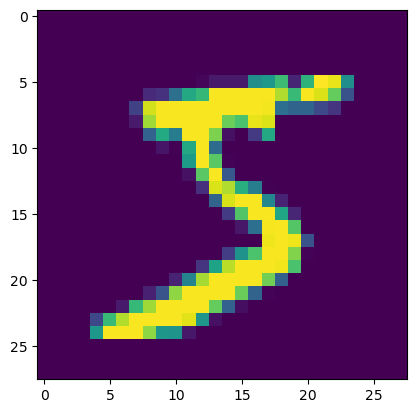

In [302]:
plt.imshow(img_tens[0, :, :])

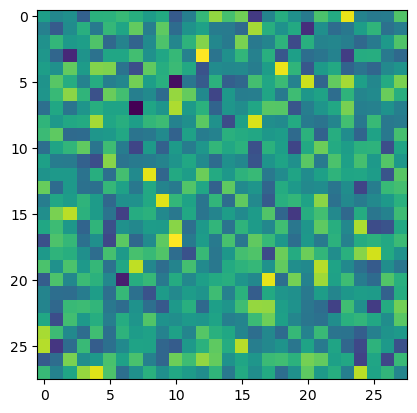

In [ ]:

plt.imshow(torch.reshape(rec_sample, (28,28)))


In [ ]:
def elbo(x_i, mu: Tensor, sigma: Tensor, log_prob: Tensor):
    # TODO: implement log prob --> what is this? is this just the pdf evaluated at this point? 
    loss: Tensor = Tensor([0])
    log_sigma_square: Tensor = torch.log(torch.square(sigma))
    ones: Tensor = torch.ones(log_sigma_square.size())
    mu_square: Tensor = torch.square(mu)
    sigma_square: Tensor = torch.square(sigma)
    return 1/2 * torch.sum(ones + log_sigma_square - mu_square - sigma_square) + log_prob

In [86]:
def train(data: Tensor, epochs: int, vae: VAE):
    optim: torch.optim.Adam = torch.optim.Adam(params=vae.parameters(), lr=0.001)
    enc: Encoder = vae.enc
    dec: Decoder = vae.dec

    xs: List = [] #TODO data add 
    for epoch in range(epochs):
        for x in xs:
            enc_mu_sigma: Tuple[Tensor, Tensor] = enc.__forward__(x)



    # optimizer

    # 


    return None

In [98]:
norm = torch.distributions.Normal(0,1)

In [99]:
torch.exp(norm.log_prob(Tensor([0])))

tensor([0.3989])